In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
from functools import partial
import seaborn as sns
import matplotlib.pylab as plt
import plotly.express as px

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [133]:
class hitseq():
    def __init__(self, refseq = "AAAAAG", filename_input = "input_data.csv"):
         self.df = pd.read_csv(filename_input, header=0)
         self.refsequence = refseq
         self.ref_row_number = self.df[self.df.iloc[:,0] == self.refsequence].index[0] - 2
         self.enzyme_concentration =  self.df.iloc[1,1:]
         #Calculate binding fractions (1-f)
         self.binding_fraction = 1 - self.df.iloc[0,1:].astype(float)
         #Extract sequence counts and reset index
         self.sequence_count = self.df.iloc[2:,1:]
         self.library = self.df.iloc[2:,0].reset_index().drop("index",axis=1)
         self.qc = self.sequence_count.iloc[:,1].astype(float).apply(self.threshold_check).reset_index(drop=True).apply(pd.Series)
    
    def threshold_check(self, x, count_threshold=300):
        if x >= count_threshold:
            return "OK"
        else:
            return "NG"
        
    def HitsEQfit(self, x, K):
        return x/(x+K)
    
    def curvefit(self, func, x, y, k_initial):
        return tuple(curve_fit(func, x, y, p0=k_initial))
    
    def HitsEQfitting(self, k_initial):
        fit = partial(self.curvefit, self.HitsEQfit, self.enzyme_concentration, k_initial=k_initial)

        """Data formatting for fitting"""
        #Calculate summation of sequence counts for each data point.
        Dt_all = self.sequence_count.sum()
        #Calculate Dt/Dt1
        Dt_Dt1_all = Dt_all[0]/Dt_all
        #Extract all the D0
        D0_ = self.sequence_count.iloc[:,0]
        #Calculate D1/D0
        D1fD0 = self.sequence_count.divide(D0_,axis='rows')
        #Create table for fitting
        fitting_table = 1 - (Dt_Dt1_all * self.binding_fraction * D1fD0)
        #Assign a very small random value for each value less than 0 in order to make sure the fitting can be performed well.
        fitting_table[fitting_table < 0] = np.random.randint(1,9)/100000
        #Reset the index of fitting table
        fitting_table = fitting_table.reset_index()
        fitting_table = fitting_table.drop("index",axis = 1)
        """Fitting"""
        K = fitting_table.apply(fit, axis=1).apply(pd.Series)

        """Formatting fitting HiTSEQ result"""
        #Organize format
        K.columns = ["K", "pcov"]
        finalresult = K.explode(["K", "pcov"]).explode("pcov").reset_index(drop=True)
        finalresult[["id"]] = self.library
        #Convert Kd to Ka
        finalresult[["KA"]] = (1/finalresult.K).apply(pd.Series)
        #Calculate Ka to relative Ka
        finalresult[["RKA"]] = (finalresult.KA/finalresult.KA[self.ref_row_number]).apply(pd.Series)
        finalresult[["qc"]] = self.qc
        #Rearrange the columns
        cols = ['id', 'K', 'KA', 'RKA','pcov', 'qc']
        finalresult = finalresult[cols]
        #Make summary for pcov. You might use pcov to galance the fitting quality.
        finalresult.pcov.astype(float).describe(percentiles=[.25, .5, .75],include=all)
        self.fitting_solution = finalresult
        return finalresult
        #Partial functions allow us to fix a certain number of arguments of a function and generate a new function.
    
    def HiTSEQ_Equation(self):
        #Calculate S1/S2
        S1 = self.sequence_count.iloc[self.ref_row_number,:]
        S10 = S1[0]
        Step1 = 1/(self.sequence_count.divide(self.sequence_count.iloc[:,0], axis=0))
        refs = S1/S1[0]
        div_ = Step1 * refs * (1+ self.enzyme_concentration) -1
        rKd = self.enzyme_concentration/div_
        RKA = 1/rKd
        RKA = RKA.apply(pd.Series).reset_index().drop("index", axis=1)
        RKA.columns = self.enzyme_concentration
        RKA["id"] = self.library
        RKA["qc"] = self.qc
        self.equation_solution = RKA
        return RKA
    
    def compare_eq_fit(self, plot_column = 7):
        plotdata = self.fitting_solution.merge(self.equation_solution, on="id", how='left')
        res = stats.linregress(plotdata.RKA.astype(float), plotdata.iloc[:,plot_column].astype(float))
        sns.scatterplot(x=plotdata.RKA, y=plotdata.iloc[:,plot_column], hue=plotdata.qc_x, alpha = 0.1)
        plt.text(0.5, plotdata.iloc[:,plot_column].max()-0.5, f"R-squared: {res.rvalue**2:.2f}", horizontalalignment='left', size='medium', color='black')
        print(plotdata.head())
    
    def interactive_plot(self, plot_column = 7):
        plotdata = self.fitting_solution.merge(self.equation_solution, on="id", how='left')
        fig = px.scatter(plotdata, x='RKA', y='3', color='qc_x', custom_data=['id','RKA'])
        #set hover
        fig.update_traces(
            hovertemplate = "<br>".join([
                "Sequence: %{customdata[0]}",
                "RKA: %{customdata[1]}"])
                )
        fig.show()

In [134]:
EQ_object = hitseq(refseq = "AAAAAG", filename_input = "input_data.csv")

In [135]:
equation_solution = EQ_object.HiTSEQ_Equation()

In [136]:
equation_solution

1,0.0,6.67,20.0,60.0,id,qc
0,NaN,1.582821,1.18165,1.290995,AAAAAA,OK
1,NaN,1.366137,1.344212,1.240072,AAAAAC,OK
2,NaN,1.0,1.0,1.0,AAAAAG,OK
3,NaN,1.646104,1.582885,1.774441,AAAAAT,OK
4,NaN,1.83052,2.135988,2.060999,AAAACA,OK
...,...,...,...,...,...,...
4091,NaN,1.859724,2.624131,2.989578,TTTTGT,OK
4092,NaN,1.589378,2.101051,2.239425,TTTTTA,OK
4093,NaN,1.383889,1.793928,2.029128,TTTTTC,OK
4094,NaN,1.133985,1.718453,2.256999,TTTTTG,OK


In [137]:
fitting_solution = EQ_object.HitsEQfitting(k_initial = 1)

In [138]:
fitting_solution
#fitting_solution

,id,K,KA,RKA,pcov,qc
0,AAAAAA,7.96889,0.125488,1.885934,2.596841,OK
1,AAAAAC,8.600381,0.116274,1.747457,0.477099,OK
2,AAAAAG,15.0288,0.066539,1.000000,0.144638,OK
3,AAAAAT,6.204218,0.161181,2.422352,0.366085,OK
4,AAAACA,4.82366,0.207311,3.115642,0.054333,OK
...,...,...,...,...,...,...
4091,TTTTGT,4.338817,0.230478,3.463801,0.010832,OK
4092,TTTTTA,5.607952,0.178318,2.679909,0.012251,OK
4093,TTTTTC,6.969578,0.143481,2.156343,0.073797,OK
4094,TTTTTG,8.721776,0.114656,1.723135,1.692652,OK


       id         K        KA       RKA      pcov qc_x  0.0      6.67  \
0  AAAAAA   7.96889  0.125488  1.885934  2.596841   OK  NaN  1.582821   
1  AAAAAC  8.600381  0.116274  1.747457  0.477099   OK  NaN  1.366137   
2  AAAAAG   15.0288  0.066539  1.000000  0.144638   OK  NaN       1.0   
3  AAAAAT  6.204218  0.161181  2.422352  0.366085   OK  NaN  1.646104   
4  AAAACA   4.82366  0.207311  3.115642  0.054333   OK  NaN   1.83052   

       20.0      60.0 qc_y  
0   1.18165  1.290995   OK  
1  1.344212  1.240072   OK  
2       1.0       1.0   OK  
3  1.582885  1.774441   OK  
4  2.135988  2.060999   OK  


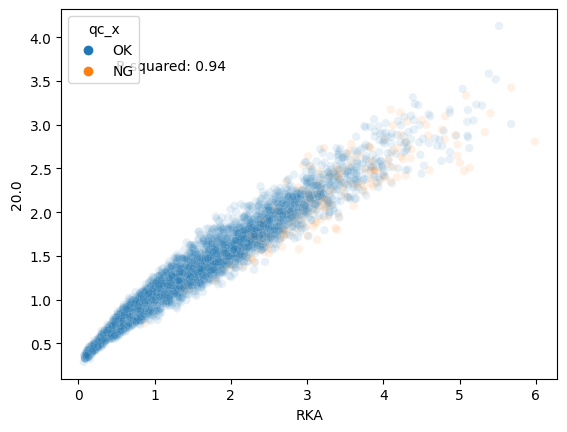

In [140]:
EQ_object.compare_eq_fit(8)